# Importing the libraries and files

In [111]:
# import libraries 
import pandas as pd
pd.options.display.float_format = '{:,.0f}'.format ##or .map({:,.0f})
import numpy as np
import matplotlib.pyplot as plt
#only in notebooks  % matplotlib inline
from matplotlib import style
style.use('ggplot')
import seaborn as sns            ##for pairplots..

import statsmodels.formula.api as smf
import statsmodels.api as sm     #for qqplots
import statsmodels.stats as sms  #for VIF

import scipy.stats as stats      #for normal distrib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import sklearn.preprocessing as prepro
pd.options.display.max_columns=60

import util_formula ## a set of functions and variables  used 

import sklearn.preprocessing as prepro

# read the data
train = pd.read_csv('data/P1train.csv', index_col=0)
test = pd.read_csv('data/P1test.csv', index_col=0)
county_facts_dictionary = pd.read_csv('data/county_facts_dictionary.csv')

# Preprocessing

In [112]:
#Step 1-3 : only the first 52 columns
#Col used to compute The WMSE

New_index = [str(i)+' '+list(train.index)[i] for i in range(len(train.index))]
train.index=pd.Index(New_index)

train['n']=train['Bernie Sanders']+train['Hillary Clinton']
test['n']=test['Bernie Sanders']+test['Hillary Clinton']

train.drop(columns=['Bernie Sanders', 'Donald Trump', 'Hillary Clinton','John Kasich', 'Ted Cruz'],inplace=True)
train.HilaryPercent=train.HilaryPercent*100
test.drop(columns=['Bernie Sanders', 'Donald Trump', 'Hillary Clinton','John Kasich', 'Ted Cruz'],inplace=True)

#dropping rows with empty HilaryPercent
train.dropna(inplace=True)
test.dropna(inplace=True)


# Step 1 : Simple linear regressions


## 1.1 Features 

In [12]:
## Feature formula preparation
#Description
Cols=[
"Persons 65 years and over, percent, 2014"
,"Female persons, percent, 2014"
,"Black or African American alone, percent, 2014"
,"High school graduate or higher, percent of persons age 25+, 2009-2013"
,"Persons below poverty level, percent, 2009-2013"]

##5 features ['AGE775214', 'SEX255214', 'RHI225214', 'EDU635213', 'PVY020213']
Features = util_formula.GetDescrCodes(Cols,util_formula.GetDics(county_facts_dictionary)[1])

#5 features with np.sqrt(RHI225214)
Featuressqrt=util_formula.GetDescrCodes(Cols,util_formula.GetDics(county_facts_dictionary)[1])
Featuressqrt[2]='np.sqrt('+Featuressqrt[2]+')' 

##Formula used in the linear regression
seperator = '+'
Formula ='HilaryPercent ~ '+seperator.join(Features)
Formulasqrt='HilaryPercent ~ '+seperator.join(Featuressqrt)

## 1.2 Fitting and Evaluation of first modals 

In [14]:
#Getwsme_OLS Performs :
#1train_test plit
#2Linear Regression on training set
#3returns wsme error metrics
#4Add pred and err to train_x_
#5Return lm,train_x_,test_x_,train_err,test_err

modal = util_formula.Getwsme_OLS('HilaryPercent',train,Formula,'1st step')[0]
modal.summary()

modalsqrt = util_formula.Getwsme_OLS('HilaryPercent',train,Formulasqrt,'1st step sqrt')[0]
modalsqrt.summary()

1st step
train error = 52.9732
test error  = 80.0345
1st step sqrt
train error = 54.6186
test error  = 77.658


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          HilaryPercent   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     599.6
Date:                Sun, 29 Sep 2019   Prob (F-statistic):               0.00
Time:                        19:05:16   Log-Likelihood:                -7424.0
No. Observations:                1993   AIC:                         1.486e+04
Df Residuals:                    1987   BIC:                         1.489e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             75.6881      6.057     12.496      0.000      63.810      87.567
AGE775214              0.4936      0.055      9.014      0.000       0.386       0.601
SEX255214              0.5660      0.102      5.568      0.000       0.367       0.765
np.sqrt(RHI225214)     5.5994      0.131     42.649      0.000       5.342       5.857
EDU635213             -0.7727      0.043    -17.955      0.000      -0.857      -0.688
PVY020213             -0.3484      0.047     -7.363      0.000      -0.441      -0.256
==============================================================================
Omnibus:                       68.447   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.692
Skew:                          -0.227   Prob(JB):                     1.26e-30
Kurtosis:                       4.205   Cond. No.                     2.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 1.3 Diagnosis of linear regression

In [18]:
def diagnosisplot(lm,Features):
    '''plotting Histogram of normalized residuals
       quantile-quantile plot of the residuals
       residuals against fitted value
       partial plots'''
    #1-1Histogram of normalized residuals
    res = lm.resid
    f1 = plt.figure(figsize=(8,6))
    f1 = plt.hist(lm.resid_pearson,bins=20)
    f1 = plt.ylabel('Count')
    f1 = plt.xlabel('Normalized residuals') 

    #1-2 check the normality of the residuals
    #quantile-quantile plot of the residuals
    fig2 = plt.figure(figsize=(10,10))
    fig = sm.qqplot(lm.resid, stats.distributions.norm, line='r') 
    
    #1-3 residuals against fitted value
    fig=plt.figure(figsize=(8,6))
    ax=fig.add_subplot(111)
    ax.scatter(lm.fittedvalues,lm.resid)
    ax.axhline(y=0, linewidth=2, color = 'g')
    ax.set(xlabel='fitted values',ylabel='residuals')
    
    #2 partial plots
    for i in range(0,len(Features)):
        fig1 = plt.figure(figsize=(20,10))
        fig1 = sm.graphics.plot_regress_exog(lm, Features[i],fig=fig1)        

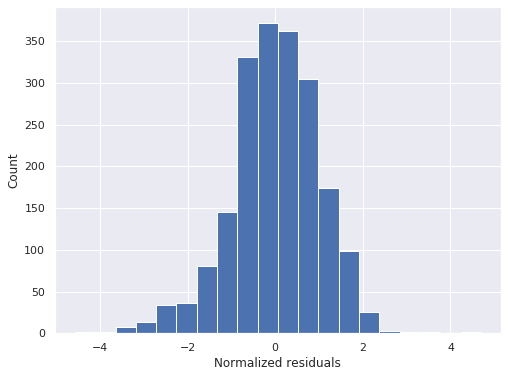

<Figure size 720x720 with 0 Axes>

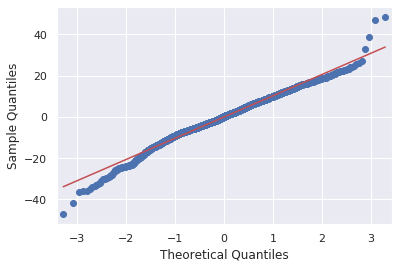

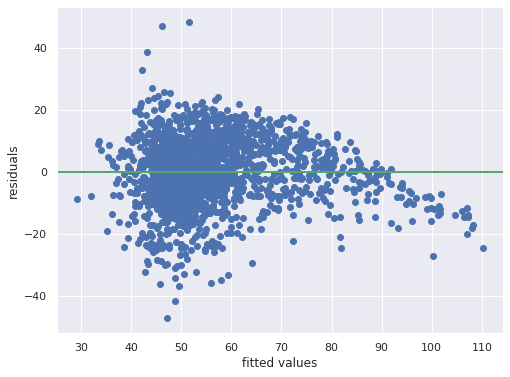

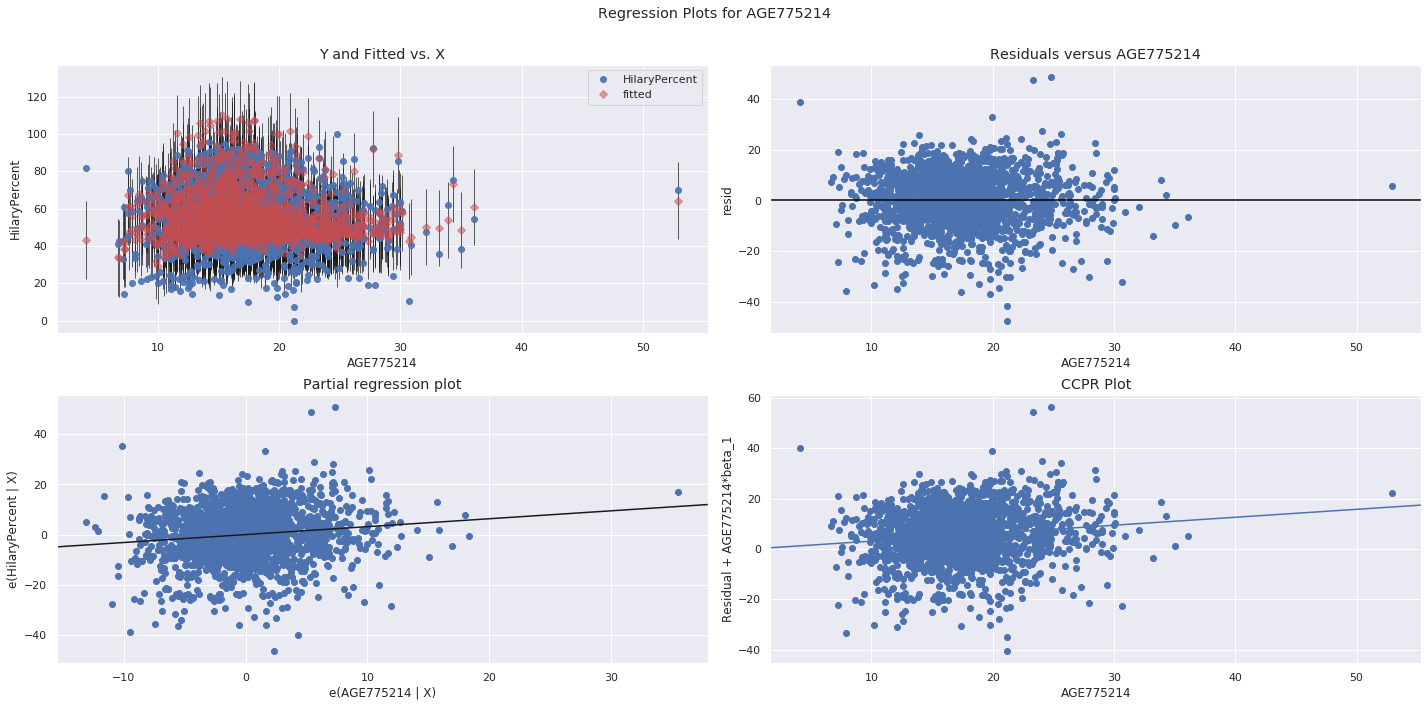

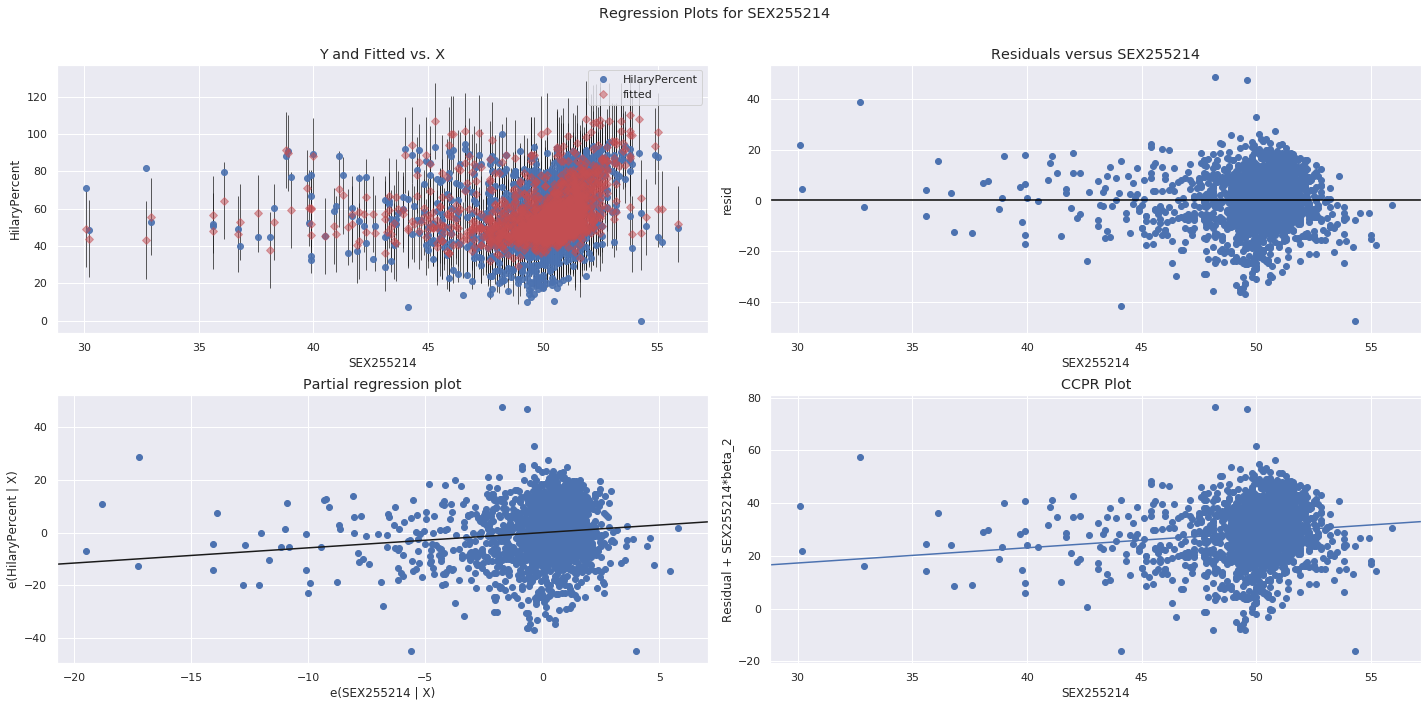

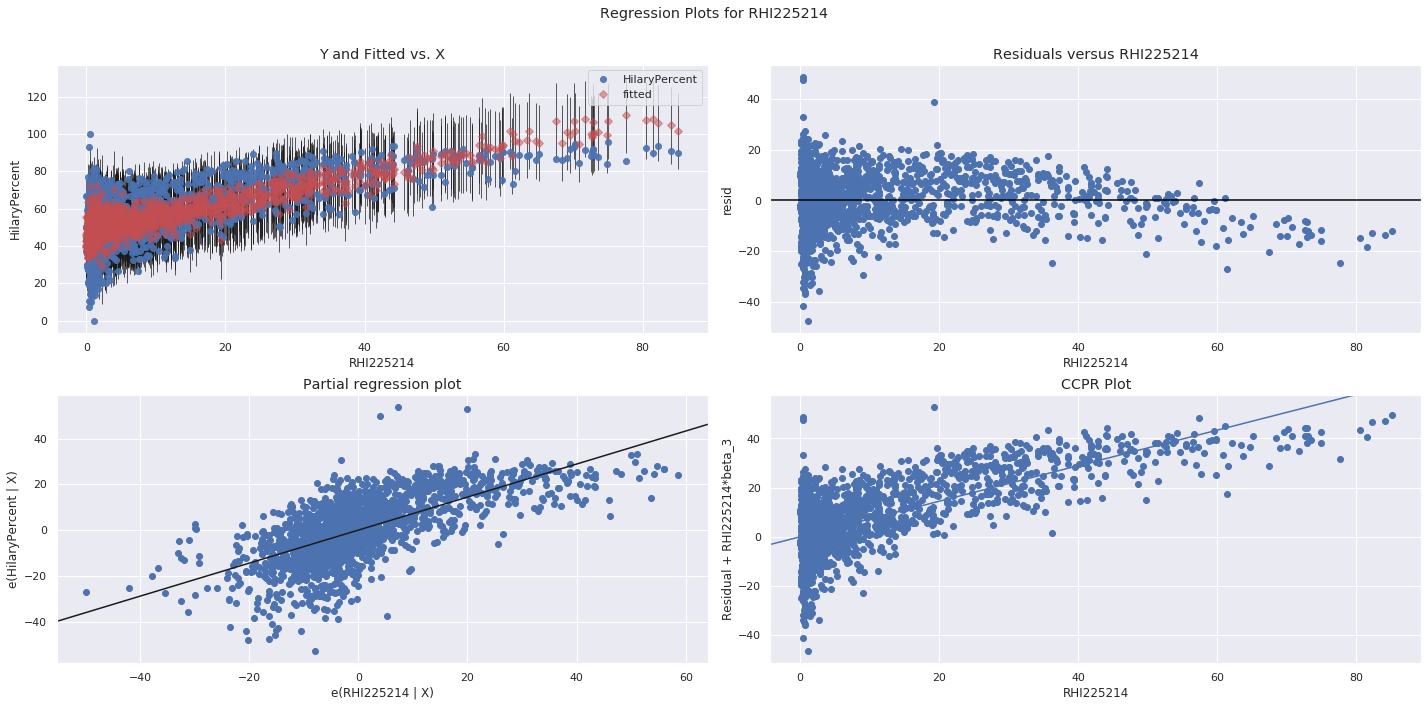

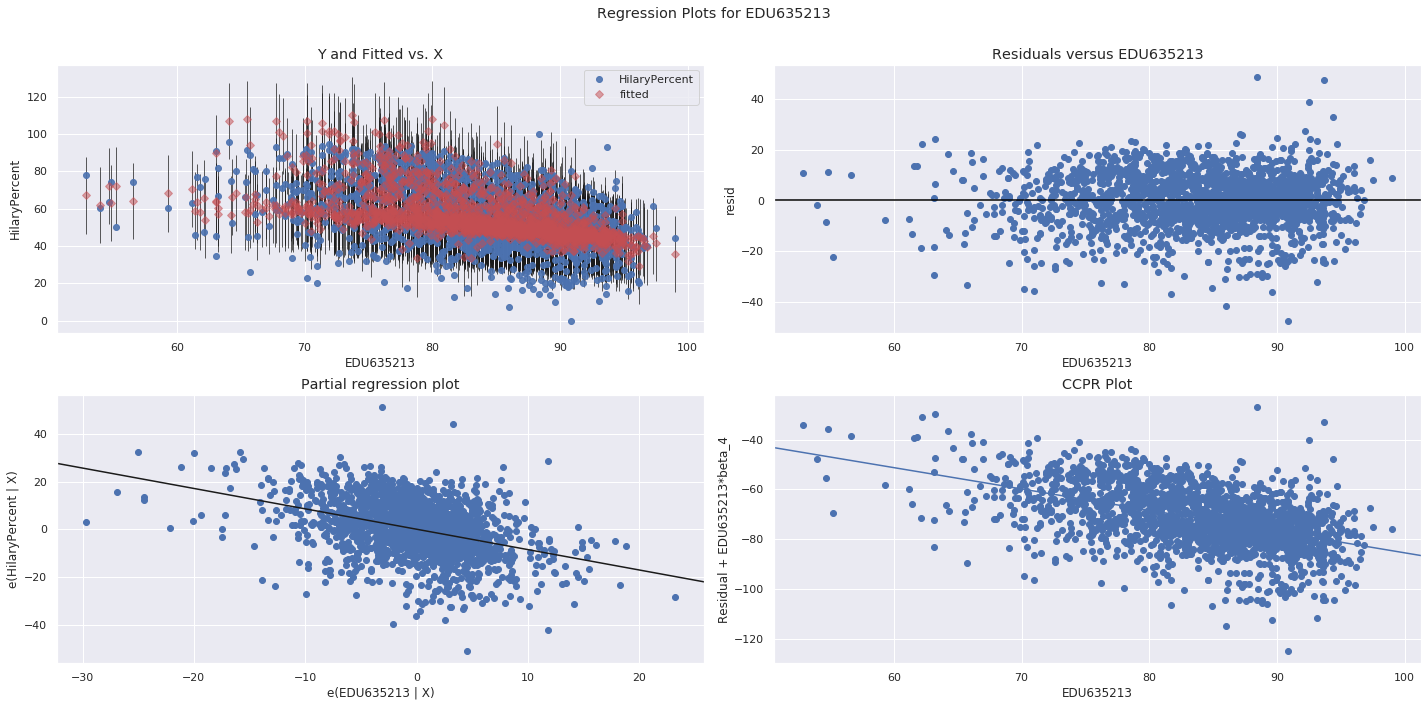

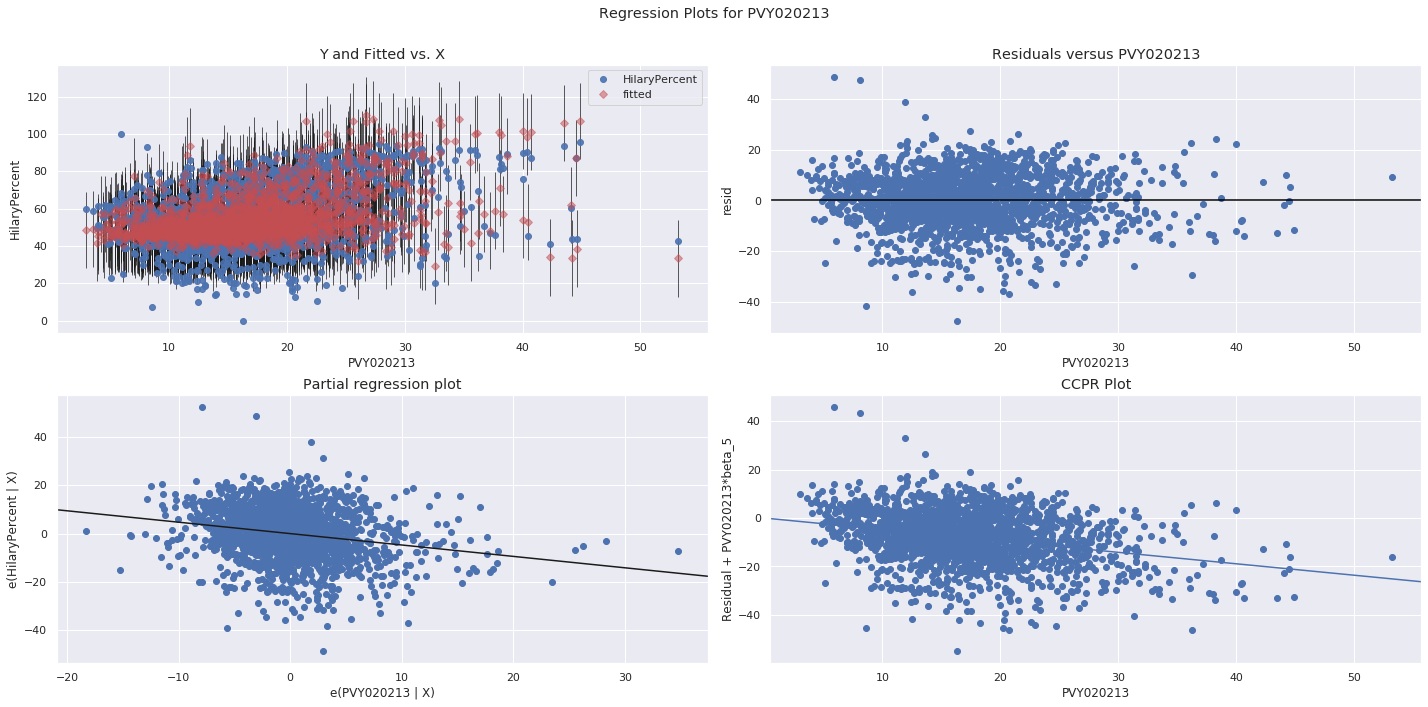

In [19]:
#plots for simple modal 
sns.set(font_scale=1)
diagnosisplot(modal,Features)

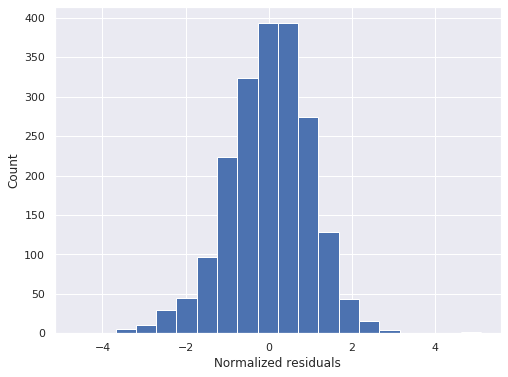

<Figure size 720x720 with 0 Axes>

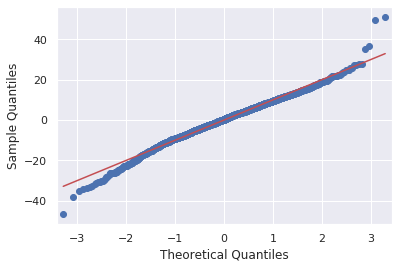

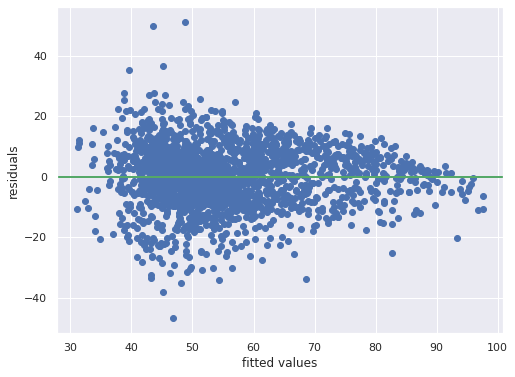

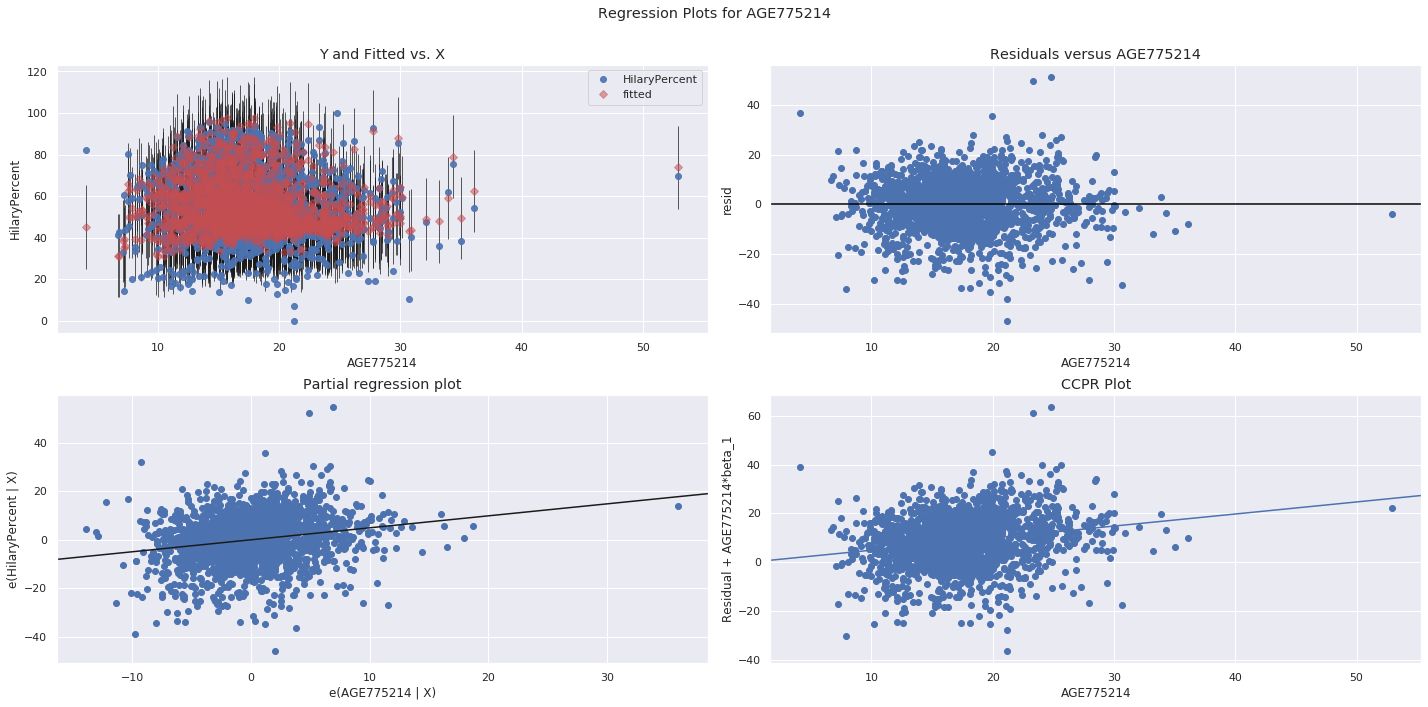

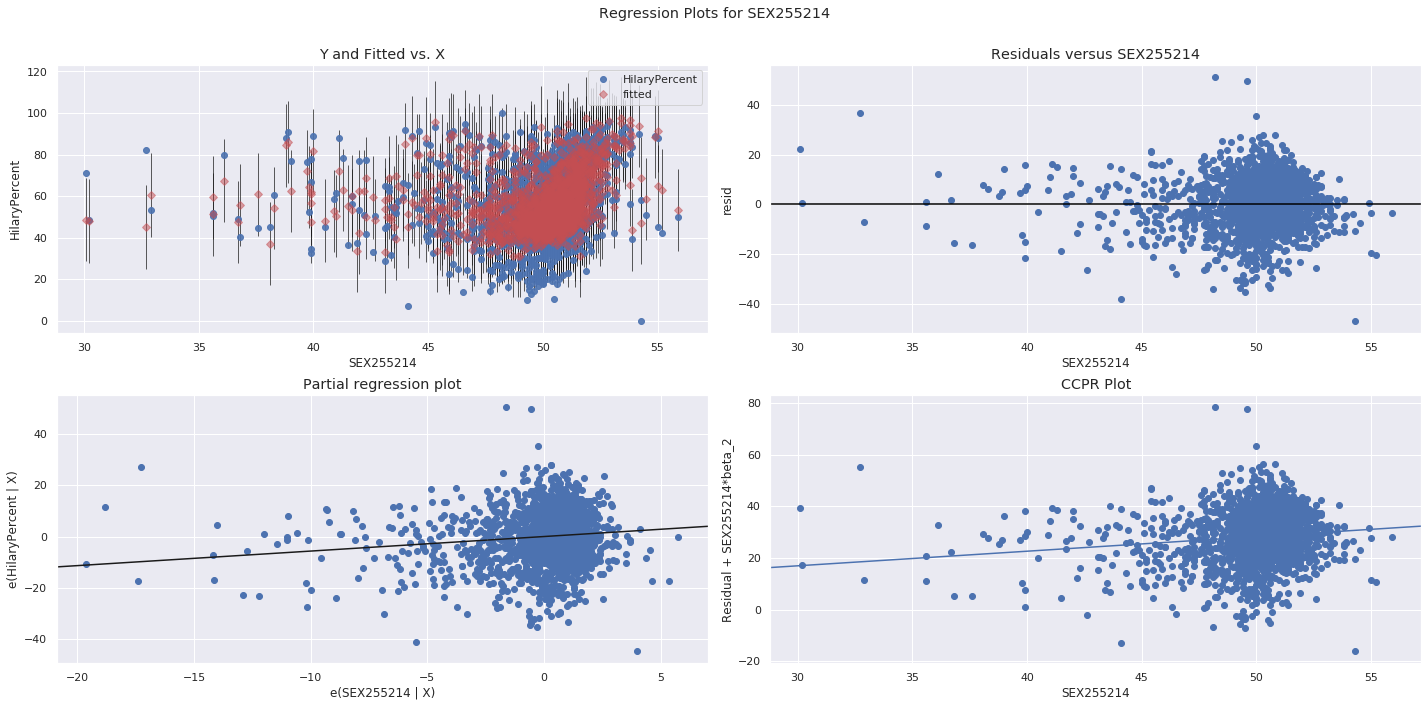

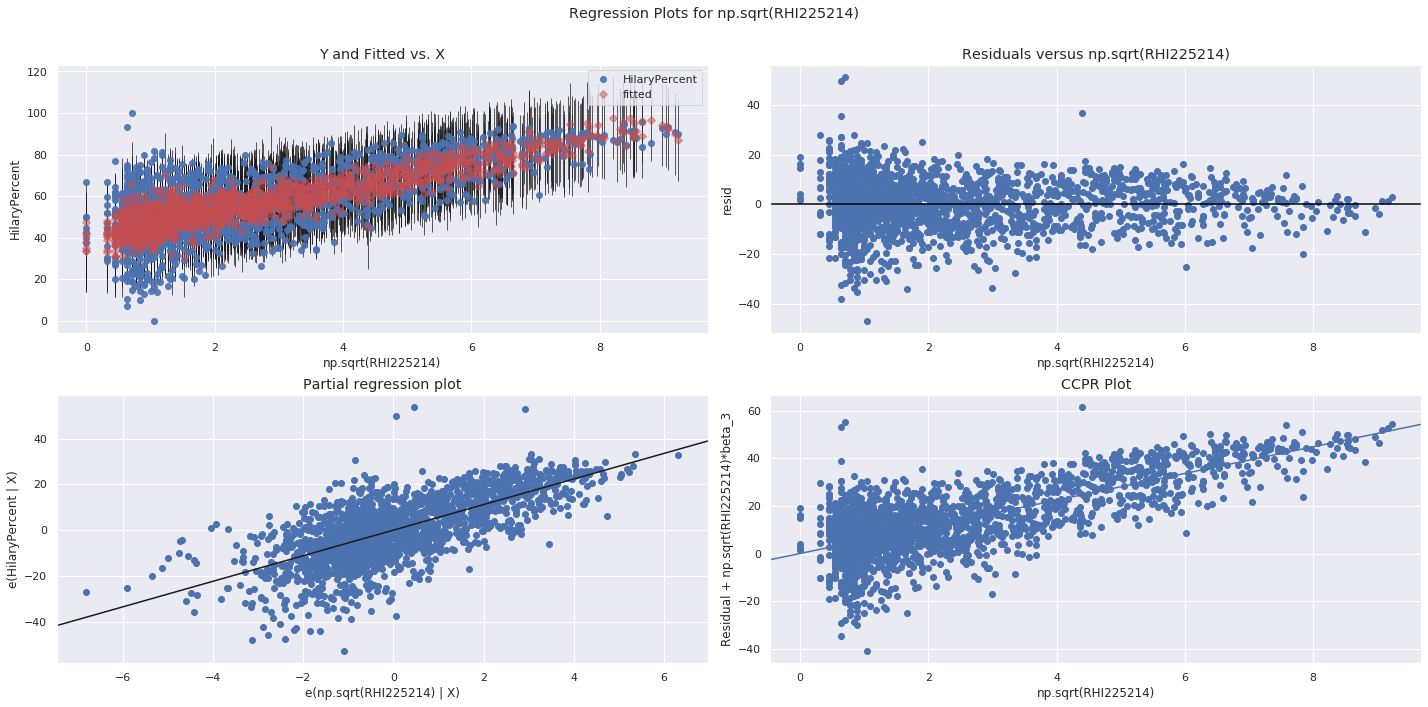

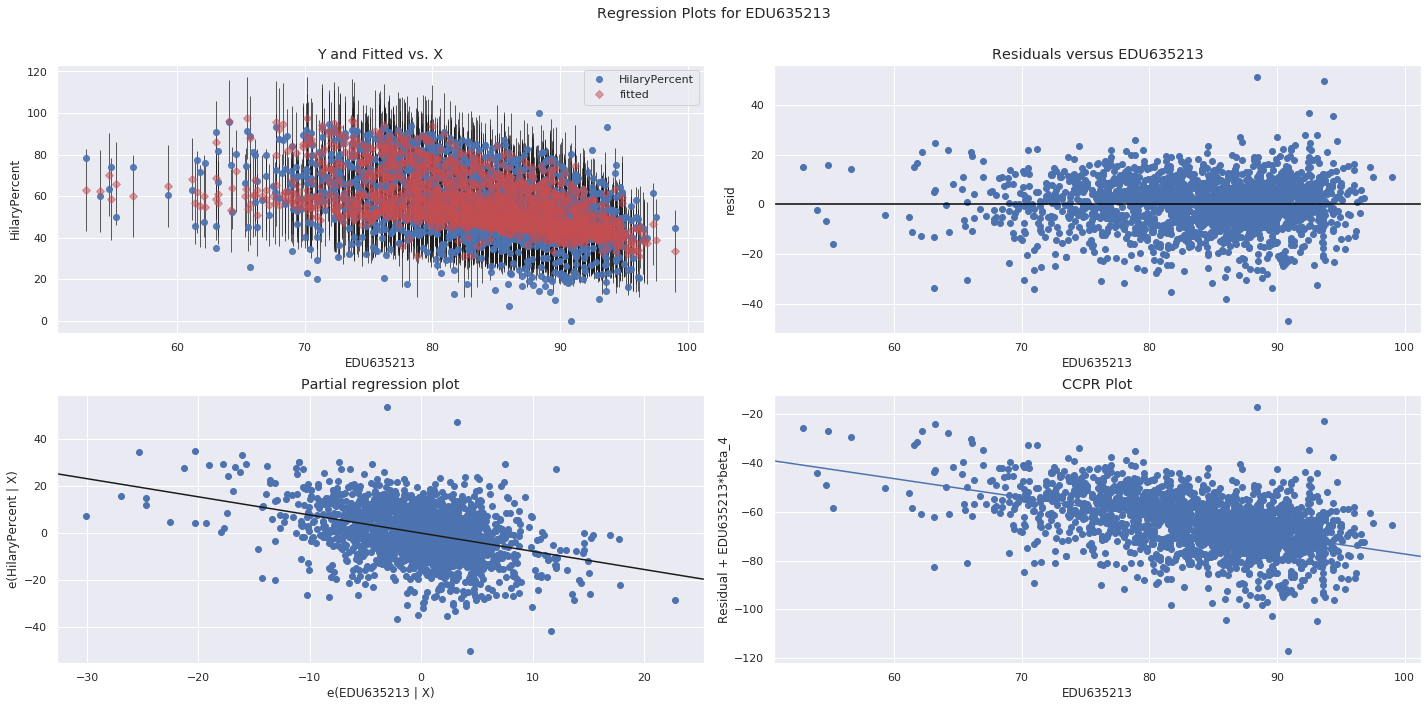

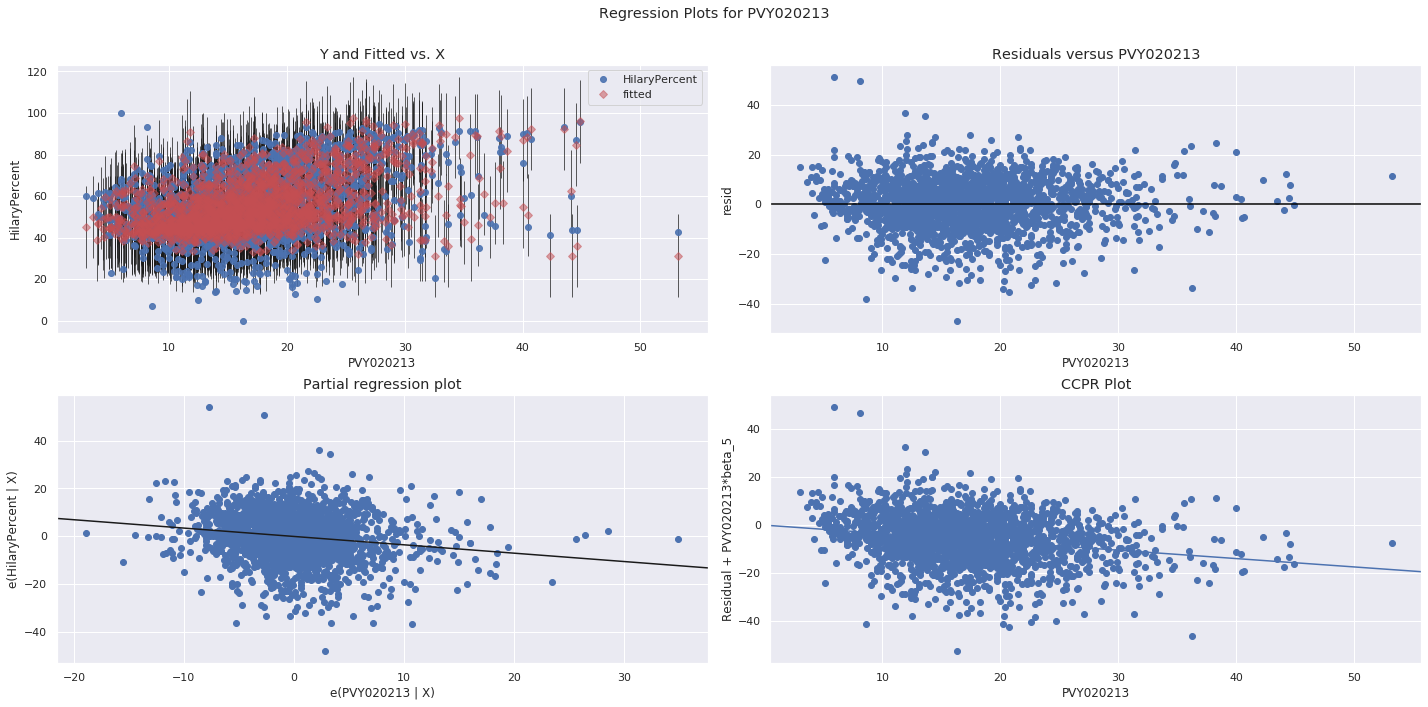

In [20]:
#plots for simple modal with sqrt 
diagnosisplot(modalsqrt,Featuressqrt)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


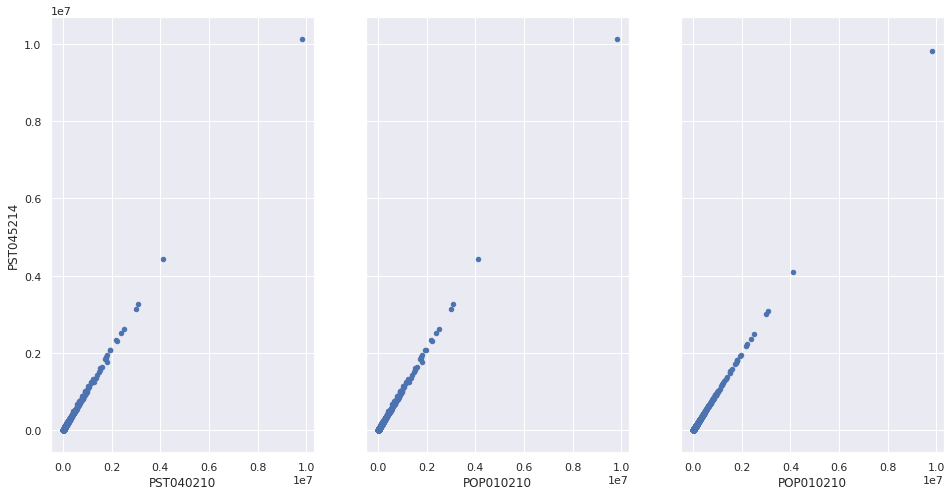

In [25]:
#clearly some colinear relationship between 2010 and April 2010
#visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 3, sharey=True)

train.plot(kind='scatter', y='PST045214', x='PST040210', ax=axs[0], figsize=(16, 8))
train.plot(kind='scatter', y='PST045214', x='POP010210', ax=axs[1])
train.plot(kind='scatter', y='PST040210', x='POP010210', ax=axs[2])

## 1.4 Outliers and influence points 

Population, 2014 estimate                                                 4,050
Population, 2010 (April 1) estimates base                                 4,087
Population, percent change - April 1, 2010 to July 1, 2014                   -1
Population, 2010                                                          4,087
Persons under 5 years, percent, 2014                                          3
Persons under 18 years, percent, 2014                                        13
Persons 65 years and over, percent, 2014                                     16
Female persons, percent, 2014                                                30
White alone, percent, 2014                                                   95
Black or African American alone, percent, 2014                                3
American Indian and Alaska Native alone, percent, 2014                        1
Asian alone, percent, 2014                                                    0
Native Hawaiian and Other Pacific Island

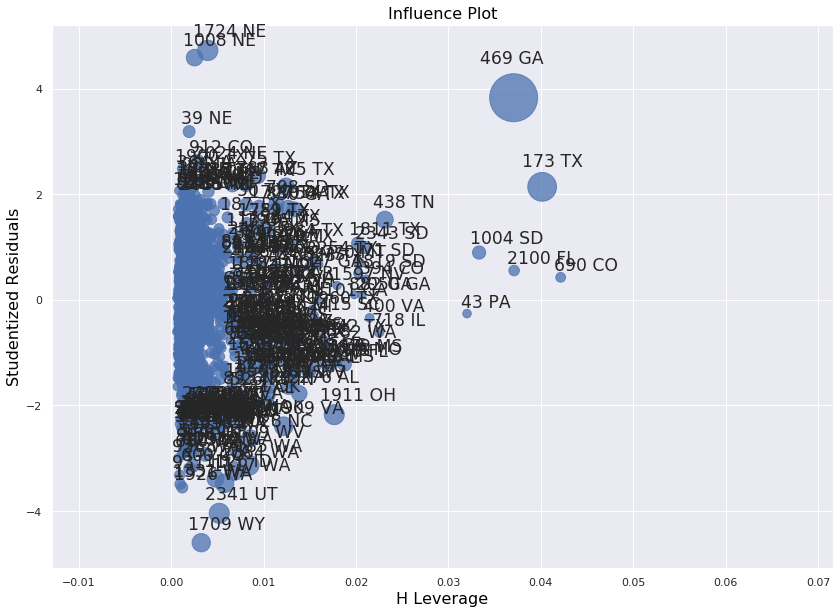

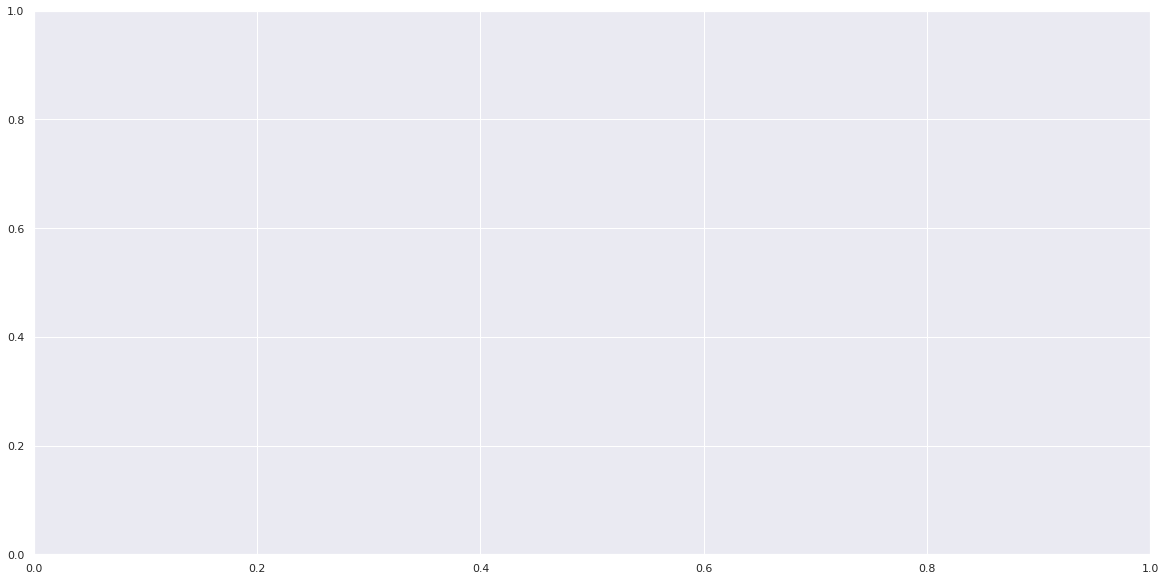

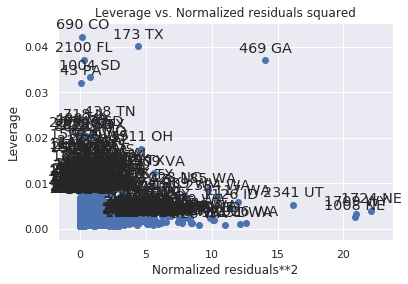

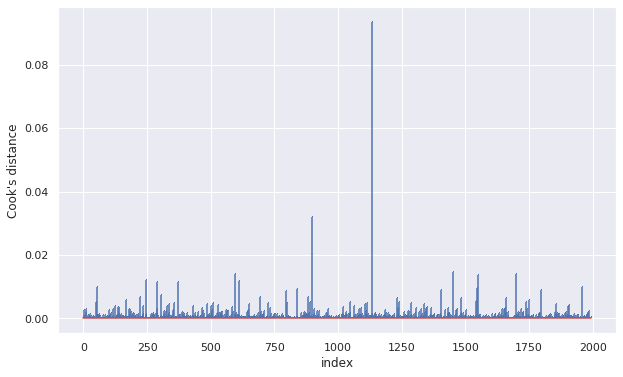

In [29]:
fig, ax = plt.subplots(figsize=(14,10))
fig = sm.graphics.influence_plot(modal, ax=ax, criterion="cooks")

fig1, ax = plt.subplots(figsize=(20,10))
fig1=sm.graphics.plot_leverage_resid2(modal,ax=ax)

#low leverage influential points 
    #positive res
        #1883 NE 
        #1724 NE
        #1008 NE 
        #39 NE 
        #912 CO
    #negative res
        #1126 ID
        #1369 UT
        #2341 UT
#high leverage and high influential points 
        #469 GA
        #173 TX

## check the leverage and influential points
influence = modal.get_influence()
#c is the distance and p is p-value
(c, p) = influence.cooks_distance
fig,ax = plt.subplots(figsize=(10,6))
#ax.set
fig = plt.stem(np.arange(len(c)), c, markerfmt=",",use_line_collection=True) 
plt.ylabel("Cook's distance")
plt.xlabel('index')

### Checking some potential outilers points 
util_formula.meaning(train).iloc[c.argmax()]
util_formula.meaning(train).loc['1883 NE']
util_formula.meaning(train).loc['1724 NE']
util_formula.meaning(train).loc['1008 NE']
util_formula.meaning(train).loc['39 NE']
util_formula.meaning(train).loc['912 CO']

util_formula.meaning(train).loc['2341 UT']
util_formula.meaning(train).loc['1369 ID']
util_formula.meaning(train).loc['1126 ID']

util_formula.meaning(train).loc['469 GA']
util_formula.meaning(train).loc['173 TX']


## 1.5 Collinearity

VIF for Intercept:726.2140600438565
VIF for AGE775214:1.0588089877517963
VIF for SEX255214:1.0438512932248944
VIF for RHI225214:1.3246224792206658
VIF for EDU635213:1.7598014856869153
VIF for PVY020213:1.9340751008710129


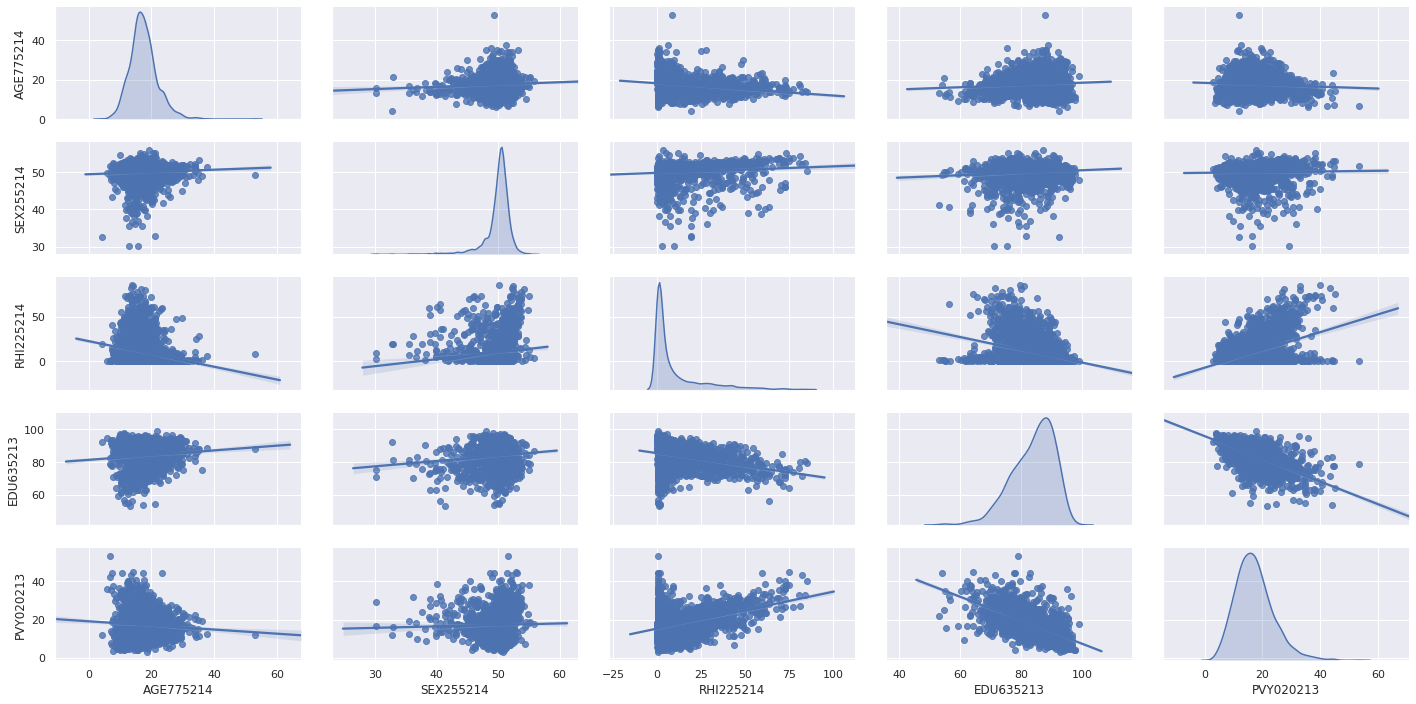

In [33]:
# pair plot of some variables of interest
sns.set(font_scale=1)
b=sns.pairplot(data=train[Features],diag_kind='kde',height=2, 
aspect=2, #Size of 1 plot, width = height* aspect
kind='reg')

#Variance inflation factor
for i in range(6):
     print('VIF for '+modal.model.exog_names[i]+':'+str( sms.outliers_influence.variance_inflation_factor(modal.model.exog, i)))

# Step 2 : Multiple linear regression

In [37]:
# load the functions to be used
from util_formula import *

y = 'HilaryPercent'

Cols=[
"Persons 65 years and over, percent, 2014"
,"Female persons, percent, 2014" 
,"Black or African American alone, percent, 2014"
,"High school graduate or higher, percent of persons age 25+, 2009-2013"
,"Persons below poverty level, percent, 2009-2013"]

Features=[ 'Q("'+ x +'")' for x in Cols]
Features[2]='np.sqrt('+Features[2]+')' #np.sqrt(Q("Black or African American alone, percent, 2014"))

seperator = '+'
Features_concat=seperator.join(Features)

In [39]:
Candidates =['PST045214', 'PST120214', 'AGE135214', 'AGE295214', 'AGE775214', 'SEX255214', 'RHI125214', 'RHI225214', 'RHI325214', 'RHI425214', 'RHI525214', 'RHI625214', 'RHI725214', 'RHI825214', 'POP715213', 'POP645213', 'POP815213', 'EDU635213', 'EDU685213', 'VET605213', 'LFE305213', 'HSG010214',
       'HSG445213', 'HSG096213', 'HSG495213', 'HSD410213', 'HSD310213', 'INC910213', 'INC110213', 'PVY020213', 'BZA010213', 'BZA110213', 'BZA115213', 'NES010213', 'SBO001207', 'SBO315207', 'SBO115207', 'SBO215207', 'SBO515207', 'SBO415207', 'SBO015207', 'MAN450207', 'WTN220207', 'RTN130207', 'RTN131207', 'AFN120207',
       'BPS030214', 'LND110210', 'POP060210']
## does not include n (number of democratic voter), 'HilaryPercent', 'Population, 2010 (April 1) estimates base','Population, 2010',

## 2.1 Step 1 : Full run with 5 variables

In [ ]:
#ols modal
fullmodel = modelFitting(y, Candidates, train)
# enumerate all models and obtain the results
models = pd.DataFrame({"model":[], "SSE": [], "R2":[], "AR2": [], "AIC": [], "BIC": [], "Pnum":[]})
##modals from 3 to 5 variables : 
for i in range(3,5):
    models = models.append(getAll(i, y, Candidates, train));
    
# get the Mallow's Cp Statistic
models = getMallowCp(models, fullmodel)

findBest(models, 'R2')

In [46]:
#returns:
Features=['AGE775214','SEX255214','RHI225214','EDU635213','PVY020213']

## 2.2 Step 2 Forward selection

In [ ]:
# use forward selection to get the best model
fwmodel = forward(y, Candidates, train, 'AIC')
fwmodel.summary()
#returns
Features_fw=['RHI225214', 'EDU635213', 'RHI625214', 'INC910213', 'HSG495213', 'SBO415207', 'EDU685213', 'AGE775214', 'PST120214', 'RHI825214', 'LND110210', 'SEX255214', 'SBO315207', 'RHI425214', 'POP645213', 'AGE135214', 'HSD310213', 'POP715213', 'RHI325214', 'LFE305213', 'RHI725214', 'HSG445213', 'HSG096213', 'POP060210']
#AIC:                         1.760e+04
#R-squared:                       0.662
#Adj. R-squared:                  0.659

## 2.3 Step 2 Backward selection

In [47]:
bwmodel = backward(y, Candidates, train, 'AIC')
bwmodel.summary()
#returns
Features_bw=['PST045214', 'AGE295214', 'RHI325214', 'RHI525214', 'POP815213', 'HSG010214', 'INC110213', 'PVY020213', 'BZA110213', 'BZA115213', 'NES010213', 'SBO115207', 'SBO215207', 'SBO015207', 'MAN450207', 'WTN220207', 'RTN131207', 'AFN120207', 'BPS030214']
#AIC:                         1.757e+04
#R-squared:                       0.668
#Adj. R-squared:                  0.664

['HSG010214']
['HSG010214', 'AFN120207']
['RHI325214', 'HSG010214', 'AFN120207']
['RHI325214', 'RHI525214', 'HSG010214', 'AFN120207']
['RHI325214', 'RHI525214', 'HSG010214', 'RTN131207', 'AFN120207']
['RHI325214', 'RHI525214', 'HSG010214', 'BZA110213', 'RTN131207', 'AFN120207']
['RHI325214', 'RHI525214', 'HSG010214', 'INC110213', 'BZA110213', 'RTN131207', 'AFN120207']
['RHI325214', 'RHI525214', 'HSG010214', 'INC110213', 'BZA110213', 'SBO115207', 'RTN131207', 'AFN120207']
['RHI325214', 'RHI525214', 'HSG010214', 'INC110213', 'BZA110213', 'SBO115207', 'MAN450207', 'RTN131207', 'AFN120207']
['RHI325214', 'RHI525214', 'HSG010214', 'INC110213', 'BZA110213', 'NES010213', 'SBO115207', 'MAN450207', 'RTN131207', 'AFN120207']
['RHI325214', 'RHI525214', 'HSG010214', 'INC110213', 'BZA110213', 'NES010213', 'SBO115207', 'MAN450207', 'RTN131207', 'AFN120207', 'BPS030214']
['RHI325214', 'RHI525214', 'HSG010214', 'INC110213', 'BZA110213', 'NES010213', 'SBO115207', 'SBO215207', 'MAN450207', 'RTN131207', 

## 2.4 Step 2 include interactions in the predictors

In [ ]:
cand_2Inter = []
for p1 in Candidates:
    for p2 in Candidates:
        if p1 == p2:
            cand_2Inter.append(p1);
        else:
            cand_2Inter.append(p1+':'+p2);
                
print(cand_2Inter)
print(len(cand_2Inter))

# forward selection with interaction considered
fwmodel = forward(y, cand_2Inter, train, 'AIC')
fwmodel.summary()
#R-squared:                       0.768
#Adj. R-squared:                  0.758
#AIC:                         1.685e+04

In [48]:
#returns
Features_fw_int=['RHI125214:RHI225214', 'RHI625214:RHI825214', 'RHI825214:HSG096213', 'AGE775214:HSG096213', 'EDU635213', 'SEX255214:INC910213', 'POP715213:HSG495213', 'RHI225214:HSD410213', 'HSG495213:INC110213', 'RHI825214:POP645213', 'RHI725214:LFE305213', 'AGE295214:AGE775214', 'RHI225214:HSD310213', 'SEX255214:RHI225214', 'PST120214:PVY020213', 'AGE135214:INC110213', 'AGE775214:EDU685213', 'RHI125214:RHI425214', 'AGE295214:HSG495213', 'PST120214:RHI825214', 'POP715213:INC910213', 'EDU635213:HSG495213', 'RHI525214:POP060210', 'AGE295214:INC910213', 'SEX255214:HSG495213', 'RHI525214:SBO315207', 'SBO115207:LND110210', 'RHI325214:POP645213', 'AGE135214:HSG445213', 'RHI325214:HSG495213', 'RHI125214:INC910213', 'RHI725214:POP815213', 'AGE295214:POP815213', 'AGE135214:RHI425214', 'AGE775214:BZA115213', 'AGE135214:POP815213', 'INC910213:PVY020213', 'POP815213:HSD310213', 'RHI425214:POP645213', 'PST120214:RHI625214', 'RHI325214:VET605213', 'HSG445213:PVY020213', 'INC910213:INC110213', 'HSG495213:PVY020213', 'AGE295214:RHI225214', 'RHI225214:HSG445213', 'RHI225214:EDU685213', 'PVY020213:SBO515207', 'POP815213:LND110210', 'SBO315207:SBO015207', 'AGE135214:AGE775214', 'RHI725214:HSG495213', 'POP815213:INC110213', 'RHI225214:POP815213', 'HSG096213:SBO315207', 'RHI225214:RHI825214', 'HSG445213:BZA110213', 'RHI225214:NES010213', 'POP645213:SBO315207', 'AGE775214:RHI625214', 'AGE775214:VET605213', 'BZA115213:LND110210', 'HSG445213:WTN220207', 'AGE295214:HSG445213', 'HSG096213:LND110210', 'AGE135214:LND110210', 'LFE305213:LND110210', 'PST120214:HSG495213', 'PST120214:AGE295214', 'PST120214:EDU635213', 'PST120214:HSG445213', 'AGE775214:POP645213', 'EDU685213:INC110213', 'AGE775214:INC110213', 'RHI425214:SBO415207', 'EDU635213:INC910213', 'SEX255214', 'SEX255214:EDU635213', 'MAN450207:RTN130207', 'RHI625214:SBO315207', 'RHI825214', 'RHI225214:SBO001207', 'RHI525214:VET605213', 'RHI525214:RHI725214', 'RHI825214:SBO415207', 'HSG495213:SBO415207', 'RHI525214:POP815213', 'PST120214:AGE775214', 'PST120214:HSD310213', 'AGE775214:RHI225214', 'HSG010214:HSG445213', 'RHI525214:HSG010214', 'AGE135214:EDU635213', 'PST045214:RHI225214', 'RHI325214:HSD310213', 'SEX255214:RHI725214', 'PST120214:INC910213', 'AGE775214:HSG495213', 'AGE775214:PVY020213', 'RHI325214:PVY020213', 'SEX255214:EDU685213', 'EDU685213:PVY020213', 'POP645213:SBO115207', 'BZA115213', 'LFE305213:HSD310213', 'RHI225214:RHI625214', 'AGE775214:EDU635213', 'PST120214:INC110213', 'AGE135214:RHI225214', 'POP815213:HSG495213', 'RHI825214:NES010213', 'RHI425214:BZA115213', 'INC910213:BZA115213', 'EDU635213:EDU685213', 'AGE295214:BZA010213', 'POP815213:RTN130207', 'AGE295214:RHI625214', 'AGE775214:HSG445213', 'PST120214:AGE135214', 'RHI725214:SBO315207', 'EDU685213:AFN120207', 'POP815213:SBO315207', 'HSG445213:HSG495213', 'RHI625214:PVY020213', 'HSD410213:SBO015207', 'EDU685213:HSD310213', 'RHI325214:SBO215207', 'POP645213:SBO215207', 'SBO015207', 'POP715213:HSG010214', 'EDU685213:SBO015207', 'SBO115207:SBO415207', 'HSG096213:SBO015207', 'SBO315207:AFN120207', 'RHI225214:RHI725214', 'POP645213:HSG495213', 'RHI125214:HSG495213', 'AGE135214:NES010213', 'SBO315207:SBO215207', 'PST120214:POP060210', 'SBO315207:SBO415207', 'POP645213:INC910213', 'AGE135214:SBO315207', 'POP645213:RTN131207', 'RHI625214:LFE305213', 'POP715213:RTN131207']

In [52]:
nfold = 10
kf = KFold(nfold, shuffle=True)

ListFeatures=[Features,Featuressqrt,Candidates,Features_fw,Features_bw,Features_fw_int]
ListFormula = ['HilaryPercent ~ '+seperator.join(i) for i in ListFeatures]

Name = ['1st step with 5 features','1st step with 5 features and sqrt for RHI225214','all features','Features with fw','Features with bw','Features and second order int with fw']
modals= []

for i in range(0,len(ListFeatures)):
    Function1 = util_formula.Getwsme_OLS('HilaryPercent',train,ListFormula[i],Name[i])
    modals.append(Function1[0])
    #train_x_=Function1[1]
    print('rsquare: {}'.format(modals[i].rsquared))
    cverr= util_formula.CrossValidation('HilaryPercent',ListFeatures[i], train, kf.split(train))
    print('mean error using cross validation: {}'.format(np.mean(cverr)))
    print('\n')


1st step with 5 features
train error = 52.9732
test error  = 80.0345
rsquare: 0.5781627658600963
mean error using cross validation: 58.87410348163289


1st step with 5 features and sqrt for RHI225214
train error = 54.6186
test error  = 77.658
rsquare: 0.6014024975364157
mean error using cross validation: 58.490320416952386


all features
train error = 35.4676
test error  = 65.9824
rsquare: 0.6605397678200682
mean error using cross validation: 58.054638372222584


Features with fw
train error = 37.1801
test error  = 79.7781
rsquare: 0.6531166054423876
mean error using cross validation: 50.39128479033823


Features with bw
train error = 115.4165
test error  = 114.8296
rsquare: 0.22077800984121798
mean error using cross validation: 133.3168199153313


Features and second order int with fw
train error = 26.0399
test error  = 61.8489
rsquare: 0.7581859121621148
mean error using cross validation: 105.03300929007817




## 2.5 Step 2 Weighted linear regression

In [60]:
def CrossValidation_WLS(y, X, data, kf,weights,hasconst=False):
    """
The function compute the cross validation results 
X: is the list of all predictors to be included
y: is the dependent variable to be predicted (in string)
data: is the dataframe of all data
kf: is the kfold.split() generated by the function from sklearn
'n' column : nber of democratic votes
@return: the cross validated MSE 
"""
    results = []

    # evaluate all accuracy based on the folds
    for train_index, test_index in kf:
        d_train, d_test = data.ix[train_index,], data.ix[test_index,]

        # fit the model and evaluate the prediction
        lmfit= sm.WLS(d_train[y],
                      d_train[X],
                      weights=d_train[weights],
                      hasconst=hasconst).fit()
        prederror = wsme(d_test[y],lmfit.predict(d_test[X]),d_test['n'])
        results.append(prederror);
        
    # Wrap everything up in a nice dataframe
    return results;

In [62]:
### We will consider the features using the foward selection

## Cross valdiation with OLS
np.mean(util_formula.CrossValidation('HilaryPercent',Features_fw, train, kf.split(train)))

48.98588244265652

In [135]:
## Cross validation with WLS 
np.mean(CrossValidation_WLS('HilaryPercent', Features_fw, train[Features_fw+['HilaryPercent','PST045214','n']],  kf.split(train),weights='PST045214'))

/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


40.13354021080381

In [144]:
##modal fitting with weights= nber of democratic voters 
y='HilaryPercent'
weights='n'
X=Features_fw
lmfit2= sm.WLS(train[y],train[X],weights=train[weights]).fit()

lmfit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                
=======================================================================================
Dep. Variable:          HilaryPercent   R-squared (uncentered):                   0.991
Model:                            WLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          1.163e+04
Date:                Sun, 29 Sep 2019   Prob (F-statistic):                        0.00
Time:                        23:23:19   Log-Likelihood:                         -9920.4
No. Observations:                2492   AIC:                                  1.989e+04
Df Residuals:                    2468   BIC:                                  2.003e+04
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RHI225214      1.0946      0.066     16.526      0.000       0.965       1.225
EDU635213     -0.3147      0.051     -6.227      0.000      -0.414      -0.216
RHI625214     -1.2678      0.137     -9.229      0.000      -1.537      -0.998
INC910213      0.0012   4.79e-05     25.615      0.000       0.001       0.001
HSG495213   -9.67e-06    2.6e-06     -3.723      0.000   -1.48e-05   -4.58e-06
SBO415207      0.3274      0.035      9.372      0.000       0.259       0.396
EDU685213     -0.5736      0.035    -16.515      0.000      -0.642      -0.505
AGE775214      0.6890      0.068     10.061      0.000       0.555       0.823
PST120214      0.4819      0.047     10.330      0.000       0.390       0.573
RHI825214      0.2624      0.065      4.057      0.000       0.136       0.389
LND110210      0.0002      0.000      1.786      0.074   -1.84e-05       0.000
SEX255214      0.4990      0.120      4.166      0.000       0.264       0.734
SBO315207     -0.2770      0.032     -8.774      0.000      -0.339      -0.215
RHI425214      0.5541      0.074      7.479      0.000       0.409       0.699
POP645213     -0.0292      0.046     -0.634      0.526      -0.120       0.061
AGE135214     -0.4820      0.230     -2.100      0.036      -0.932      -0.032
HSD310213      9.2683      1.310      7.074      0.000       6.699      11.837
POP715213     -0.2401      0.053     -4.545      0.000      -0.344      -0.137
RHI325214      0.3625      0.072      5.005      0.000       0.220       0.505
LFE305213     -0.1970      0.039     -5.007      0.000      -0.274      -0.120
RHI725214      0.2385      0.060      3.994      0.000       0.121       0.356
HSG445213      0.0035      0.046      0.075      0.940      -0.087       0.094
HSG096213     -0.0429      0.029     -1.487      0.137      -0.100       0.014
POP060210     -0.0001   2.66e-05     -4.451      0.000      -0.000   -6.61e-05
==============================================================================
Omnibus:                      729.698   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12780.384
Skew:                          -0.921   Prob(JB):                         0.00
Kurtosis:                      13.941   Cond. No.                     3.41e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [136]:
##modal fitting with weights = population
y='HilaryPercent'
weights='PST045214'
X=Features_fw
lmfit= sm.WLS(train[y],train[X],weights=train[weights]).fit()

lmfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                
=======================================================================================
Dep. Variable:          HilaryPercent   R-squared (uncentered):                   0.986
Model:                            WLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                              7392.
Date:                Sun, 29 Sep 2019   Prob (F-statistic):                        0.00
Time:                        23:11:20   Log-Likelihood:                         -9801.4
No. Observations:                2492   AIC:                                  1.965e+04
Df Residuals:                    2468   BIC:                                  1.979e+04
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RHI225214      1.3321      0.077     17.304      0.000       1.181       1.483
EDU635213     -0.5705      0.056    -10.229      0.000      -0.680      -0.461
RHI625214     -1.3919      0.146     -9.561      0.000      -1.677      -1.106
INC910213      0.0013   5.94e-05     21.634      0.000       0.001       0.001
HSG495213  -1.835e-05   3.15e-06     -5.829      0.000   -2.45e-05   -1.22e-05
SBO415207      0.3793      0.040      9.553      0.000       0.301       0.457
EDU685213     -0.5318      0.042    -12.752      0.000      -0.614      -0.450
AGE775214      0.5778      0.077      7.491      0.000       0.427       0.729
PST120214      0.4394      0.054      8.072      0.000       0.333       0.546
RHI825214      0.4291      0.075      5.699      0.000       0.281       0.577
LND110210     -0.0001      0.000     -1.160      0.246      -0.000    8.47e-05
SEX255214      0.8055      0.134      6.009      0.000       0.543       1.068
SBO315207     -0.2714      0.042     -6.482      0.000      -0.354      -0.189
RHI425214      0.9538      0.091     10.522      0.000       0.776       1.132
POP645213     -0.1514      0.058     -2.630      0.009      -0.264      -0.039
AGE135214     -1.8327      0.266     -6.886      0.000      -2.355      -1.311
HSD310213      7.9165      1.460      5.421      0.000       5.053      10.780
POP715213     -0.1852      0.062     -2.973      0.003      -0.307      -0.063
RHI325214      0.5626      0.085      6.616      0.000       0.396       0.729
LFE305213     -0.1843      0.047     -3.952      0.000      -0.276      -0.093
RHI725214      0.4253      0.068      6.215      0.000       0.291       0.560
HSG445213     -0.0228      0.054     -0.419      0.675      -0.129       0.084
HSG096213     -0.1070      0.035     -3.091      0.002      -0.175      -0.039
POP060210   -8.25e-05    3.7e-05     -2.228      0.026      -0.000   -9.89e-06
==============================================================================
Omnibus:                      957.392   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16029.433
Skew:                          -1.368   Prob(JB):                         0.00
Kurtosis:                      15.120   Cond. No.                     2.84e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.84e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [146]:
## points with the biggest residuals
train['fittedvalues']=lmfit2.fittedvalues 
meaning(train.iloc[abs(lmfit2.resid_pearson).argsort()[-10:]])


,"Population, 2014 estimate","Population, 2010 (April 1) estimates base","Population, percent change - April 1, 2010 to July 1, 2014","Population, 2010","Persons under 5 years, percent, 2014","Persons under 18 years, percent, 2014","Persons 65 years and over, percent, 2014","Female persons, percent, 2014","White alone, percent, 2014","Black or African American alone, percent, 2014","American Indian and Alaska Native alone, percent, 2014","Asian alone, percent, 2014","Native Hawaiian and Other Pacific Islander alone, percent, 2014","Two or More Races, percent, 2014","Hispanic or Latino, percent, 2014","White alone, not Hispanic or Latino, percent, 2014","Living in same house 1 year & over, percent, 2009-2013","Foreign born persons, percent, 2009-2013","Language other than English spoken at home, pct age 5+, 2009-2013","High school graduate or higher, percent of persons age 25+, 2009-2013","Bachelor's degree or higher, percent of persons age 25+, 2009-2013","Veterans, 2009-2013","Mean travel time to work (minutes), workers age 16+, 2009-2013","Housing units, 2014","Homeownership rate, 2009-2013","Housing units in multi-unit structures, percent, 2009-2013","Median value of owner-occupied housing units, 2009-2013","Households, 2009-2013","Persons per household, 2009-2013","Per capita money income in past 12 months (2013 dollars), 2009-2013","Median household income, 2009-2013","Persons below poverty level, percent, 2009-2013","Private nonfarm establishments, 2013","Private nonfarm employment, 2013","Private nonfarm employment, percent change, 2012-2013","Nonemployer establishments, 2013","Total number of firms, 2007","Black-owned firms, percent, 2007","American Indian- and Alaska Native-owned firms, percent, 2007","Asian-owned firms, percent, 2007","Native Hawaiian- and Other Pacific Islander-owned firms, percent, 2007","Hispanic-owned firms, percent, 2007","Women-owned firms, percent, 2007","Manufacturers shipments, 2007 ($1,000)","Merchant wholesaler sales, 2007 ($1,000)","Retail sales, 2007 ($1,000)","Retail sales per capita, 2007","Accommodation and food services sales, 2007 ($1,000)","Building permits, 2014","Land area in square miles, 2010","Population per square mile, 2010",HilaryPercent,n,fittedvalues
92 MI,629237,602622,4,602622,7,25,12,51,83,10,1,3,0,3,10,75,84,7,11,89,32,34393,21,248724,70,24,137500,229373,3,25889,51667,16,15615,323594,1,43713,52369,6,1,3,0,2,30,15738279,13020792,8058005,13377,925177,1711,847,712,37,69274,46
1147 MO,1001876,998883,0,998954,6,22,16,53,70,24,0,4,0,2,3,68,86,7,9,92,41,70308,23,438081,71,23,174500,403293,2,34795,58910,11,30847,559606,2,72436,91810,10,0,4,0,1,27,22654565,27366632,17237496,17347,2440721,1062,508,"1,967",56,160507,62
57 MI,1764804,1820641,-3,1820584,6,24,14,52,55,39,0,3,0,2,6,50,86,8,13,84,21,105562,25,814399,65,23,86800,670987,3,22308,41184,24,31821,590972,2,126314,137728,29,1,4,0,2,37,55896948,26102859,17275751,8720,3112369,1001,612,"2,974",61,268885,66
663 NJ,669115,634277,6,634266,7,20,11,50,66,15,1,15,0,3,43,29,86,41,59,82,36,16139,34,277166,33,84,347200,243875,3,32641,58442,17,12879,211322,0,48782,55520,12,0,13,0,26,28,2614244,14524927,6099871,10350,880714,4621,46,"13,731",66,74910,58
1292 MO,317419,319365,-1,319294,7,20,11,52,47,48,0,3,0,2,4,44,78,7,10,83,30,19347,24,175355,45,53,119200,140652,2,23048,34582,27,9794,223481,-1,21248,23632,21,1,5,0,1,28,10920629,5042147,2496672,7020,1059295,758,62,"5,158",55,62206,66
1731 IN,934243,903389,3,903393,8,25,11,52,66,28,0,3,0,3,10,58,82,8,12,84,27,57036,23,419350,56,31,118000,360072,2,24124,42334,20,22741,508703,2,58749,69266,12,1,2,0,2,28,24333886,15780255,12951290,14748,2248380,1195,396,"2,280",50,118448,59
33 AL,660793,658350,0,658466,7,23,14,53,54,43,0,2,0,1,4,51,84,4,6,87,30,46613,23,305040,65,24,140800,259634,2,26906,45429,18,16232,319199,2,44987,55470,23,0,2,0,1,30,10260950,13756797,11066328,16730,1268154,2280,"1,111",592,82,81676,72
1673 VA,217853,204246,7,204214,6,18,11,52,45,50,1,2,0,2,7,40,77,7,10,82,35,12126,22,10010

In [147]:
#We will opt for the 2nd one 
lmfit2.predict(test[Features_fw]).describe()

count   300
mean     56
std      12
min      27
25%      48
50%      52
75%      62
max     102
dtype: float64

In [174]:
def sup(x):
    if x>100:
        return 100
    else:
        return x
results=lmfit2.predict(test[Features_fw]).apply(sup)

In [180]:
results.to_csv('Step2.csv',index=False)

/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
